In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [ ]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=50,
    bin_size=0,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


In [42]:
# Select the viewpoint using spherical angles
distance = 17   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 90.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R_t, T_t = look_at_view_transform(distance, elevation, azimuth, device=device)
print(R_t, T_t)

tensor([[[ 4.3711e-08,  0.0000e+00, -1.0000e+00],
         [-0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  4.3711e-08]]], device='cuda:0') tensor([[-0., -0., 17.]], device='cuda:0')


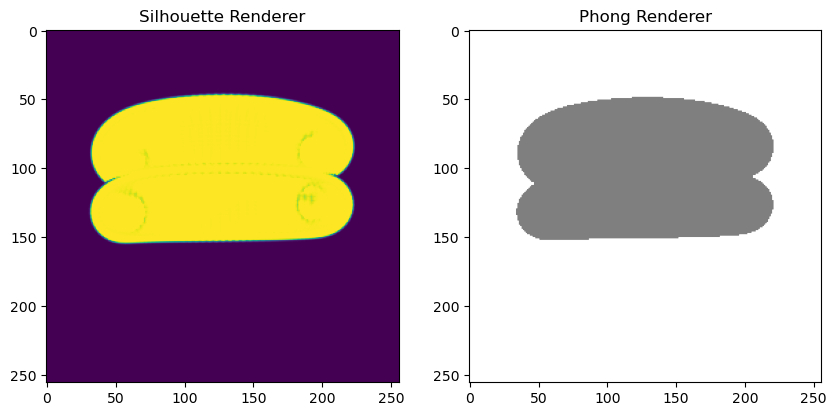

In [43]:
# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.title("Silhouette Renderer")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.title("Phong Renderer")
plt.grid(False)

In [44]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([20.0,  20.0, +20.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.mean((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [45]:
# We will save images periodically and compose them into a GIF.
#filename_output = "./teapot_optimization_demo.gif"
#writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

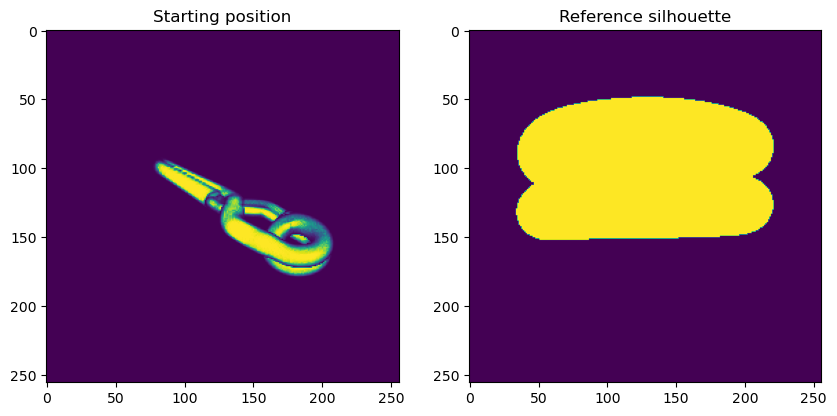

In [46]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

plt.show()

Restart 1/10
Restart 1, Iteration 0, Loss: 0.24566587805747986
Restart 1, Iteration 50, Loss: 0.23942744731903076
Restart 1, Iteration 100, Loss: 0.227992445230484
Restart 1, Iteration 150, Loss: 0.22087472677230835
Restart 1, Iteration 199, Loss: 0.21122419834136963


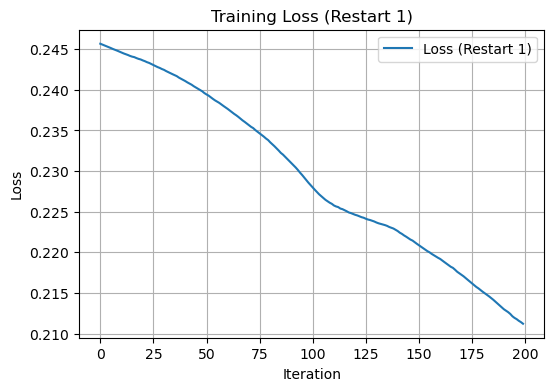

Restart 2/10
Restart 2, Iteration 0, Loss: 0.2491302192211151
Restart 2, Iteration 50, Loss: 0.24247874319553375
Restart 2, Iteration 100, Loss: 0.22840279340744019
Restart 2, Iteration 150, Loss: 0.20844005048274994
Restart 2, Iteration 199, Loss: 0.20851823687553406


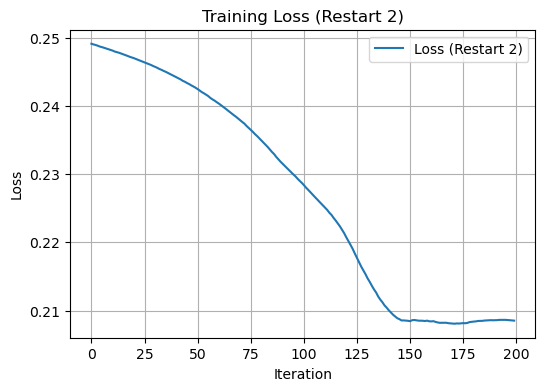

Restart 3/10
Restart 3, Iteration 0, Loss: 0.2510303258895874
Restart 3, Iteration 50, Loss: 0.25101280212402344
Restart 3, Iteration 100, Loss: 0.26664939522743225
Restart 3, Iteration 150, Loss: 0.25793951749801636
Restart 3, Iteration 199, Loss: 0.24407123029232025


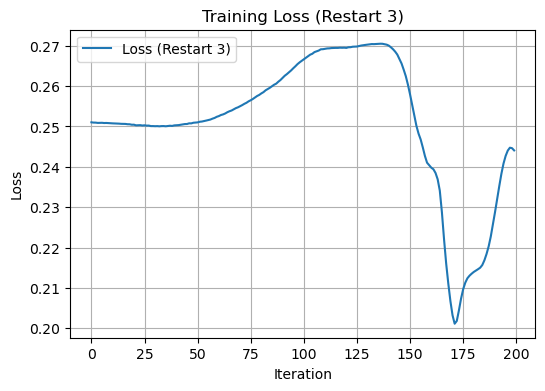

Restart 4/10
Restart 4, Iteration 0, Loss: 0.25028401613235474
Restart 4, Iteration 50, Loss: 0.2533336877822876
Restart 4, Iteration 100, Loss: 0.24961110949516296
Restart 4, Iteration 150, Loss: 0.23779505491256714
Restart 4, Iteration 199, Loss: 0.12977713346481323


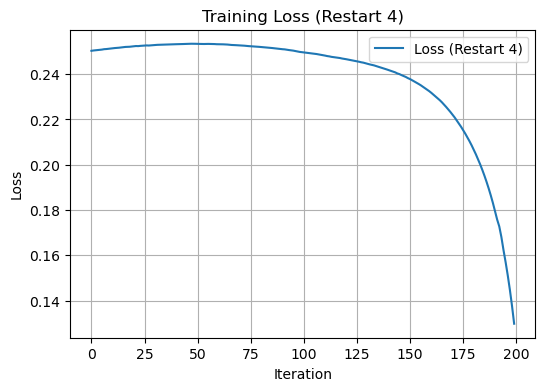

Restart 5/10
Restart 5, Iteration 0, Loss: 0.24980297684669495
Restart 5, Iteration 50, Loss: 0.24373725056648254
Restart 5, Iteration 100, Loss: 0.2301984578371048
Restart 5, Iteration 150, Loss: 0.2127222716808319
Restart 5, Iteration 199, Loss: 0.2101583331823349


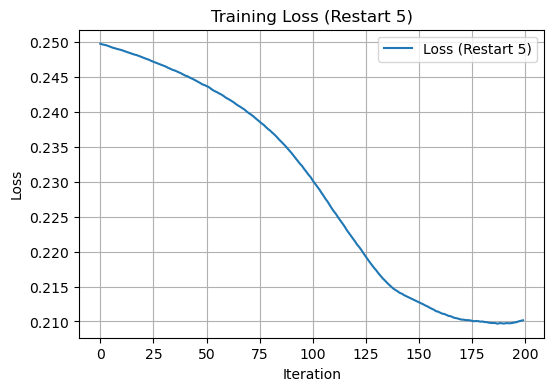

Restart 6/10
Restart 6, Iteration 0, Loss: 0.24805250763893127
Restart 6, Iteration 50, Loss: 0.24404019117355347
Restart 6, Iteration 100, Loss: 0.2363259196281433
Restart 6, Iteration 150, Loss: 0.22329579293727875
Restart 6, Iteration 199, Loss: 0.21483010053634644


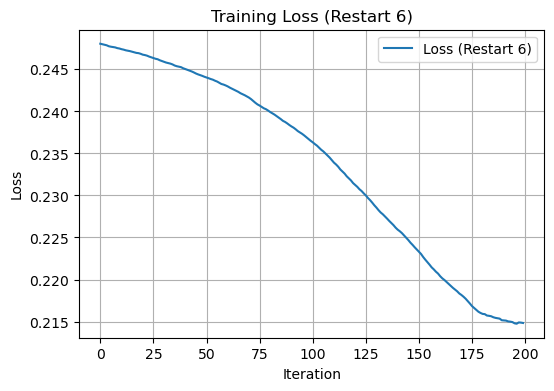

Restart 7/10
Restart 7, Iteration 0, Loss: 0.24162812530994415
Restart 7, Iteration 50, Loss: 0.2339300662279129
Restart 7, Iteration 100, Loss: 0.22334489226341248
Restart 7, Iteration 150, Loss: 0.21484428644180298
Restart 7, Iteration 199, Loss: 0.21002420783042908


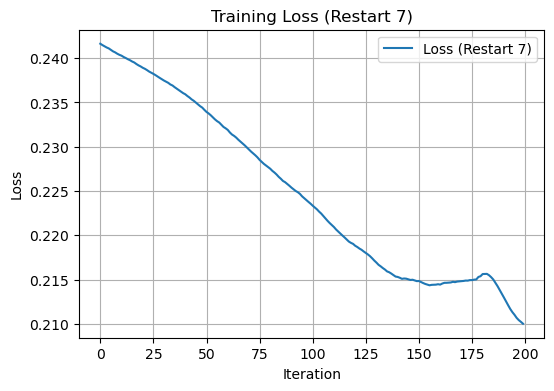

Restart 8/10
Restart 8, Iteration 0, Loss: 0.24713197350502014
Restart 8, Iteration 50, Loss: 0.23854932188987732
Restart 8, Iteration 100, Loss: 0.2232035994529724
Restart 8, Iteration 150, Loss: 0.20999369025230408
Restart 8, Iteration 199, Loss: 0.20993266999721527


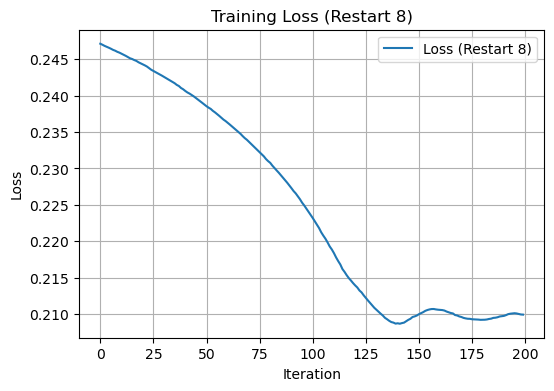

Restart 9/10
Restart 9, Iteration 0, Loss: 0.2486237734556198
Restart 9, Iteration 50, Loss: 0.24244403839111328
Restart 9, Iteration 100, Loss: 0.23100237548351288
Restart 9, Iteration 150, Loss: 0.22836074233055115
Restart 9, Iteration 199, Loss: 0.21950936317443848


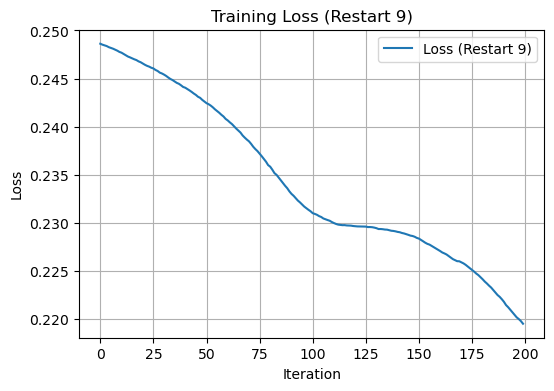

Restart 10/10
Restart 10, Iteration 0, Loss: 0.24594856798648834
Restart 10, Iteration 50, Loss: 0.24087679386138916
Restart 10, Iteration 100, Loss: 0.23174968361854553
Restart 10, Iteration 150, Loss: 0.2206067144870758
Restart 10, Iteration 199, Loss: 0.2141115367412567


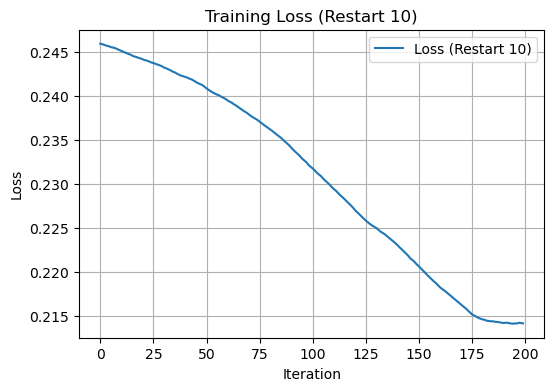

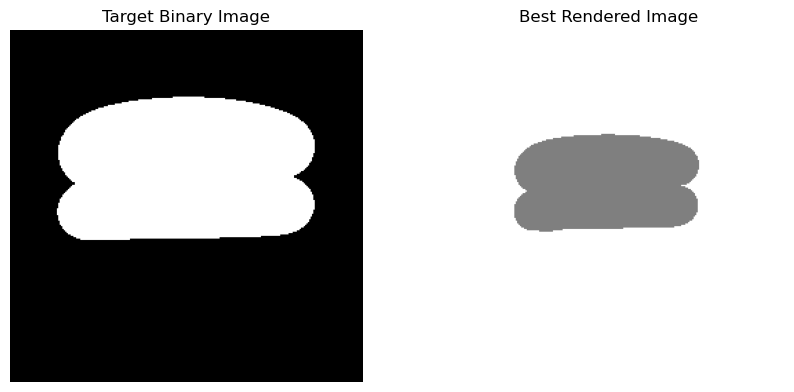

Best Training Results:
Lowest Loss: 0.12977713346481323
Best Camera Position: [19.431747    0.03790982 -0.16357741]
Best T = tensor([[-0.0000, -0.0000, 19.4325]], device='cuda:0', grad_fn=<NegBackward0>)
Best R = tensor([[[ 8.4178e-03, -1.9508e-03, -9.9996e-01],
         [-0.0000e+00,  1.0000e+00, -1.9508e-03],
         [ 9.9996e-01,  1.6422e-05,  8.4177e-03]]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [47]:
# RANDOM RESTART WITH DISTANCE CONTROL
# 
# 
# Function to generate a random camera position within a safe distance
def random_camera_position(min_distance, max_distance, device):
    # Generate a random distance within the specified range
    distance = np.random.uniform(min_distance, max_distance)
    
    # Generate random azimuth and elevation angles
    azimuth = np.random.uniform(0, 360)  # Degrees
    elevation = np.random.uniform(-90, 90)  # Degrees
    
    # Convert spherical coordinates to Cartesian coordinates
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    
    # Return the camera position as a torch tensor
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

# Safe camera position range
min_distance = 40.0  # Closest the camera can be
max_distance = 50.0  # Farthest the camera can be

# Perform multiple random restarts
num_restarts = 10
num_iterations = 200
best_loss = float('inf')
best_camera_position = None
best_rendered_image = None

for restart in range(num_restarts):
    print(f"Restart {restart + 1}/{num_restarts}")
    
    # Randomize the initial camera position
    model.camera_position.data = random_camera_position(min_distance, max_distance, device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_values = []

    # Training loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss, rendered_image = model()  # Forward pass

        # Backward pass
        loss.backward()

        # Gradient clipping (optional)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Store loss for plotting
        loss_values.append(loss.item())

        # Print progress every 50 iterations
        if i % 50 == 0 or i == num_iterations - 1:
            print(f"Restart {restart + 1}, Iteration {i}, Loss: {loss.item()}")

    # Save the best result
    if loss_values[-1] < best_loss:
        best_loss = loss_values[-1]
        best_camera_position = model.camera_position.data.clone()
        best_rendered_image = rendered_image.clone()

    # Plot the loss curve for this restart
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label=f"Loss (Restart {restart + 1})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (Restart {restart + 1})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the best camera position for final visualization
model.camera_position.data = best_camera_position

# Render the final image with the best camera position
final_rendered_image = phong_renderer(
    meshes_world=model.meshes.clone(),
    R=look_at_rotation(model.camera_position[None, :], device=model.device),
    T=-torch.bmm(
        look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2),
        model.camera_position[None, :, None]
    )[:, :, 0]
)[0, ..., :3].detach().cpu().numpy()

# Display the best result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
plt.title("Target Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_rendered_image)
plt.title("Best Rendered Image")
plt.axis("off")
plt.show()

# Print the best results
print("Best Training Results:")
print(f"Lowest Loss: {best_loss}")
print(f"Best Camera Position: {best_camera_position.cpu().numpy()}")
print(f"Best T = {-torch.bmm(look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]}")
print(f"Best R = {look_at_rotation(model.camera_position[None, :], device=model.device)}")

In [32]:
# Define the scale factor to convert mesh units to the desired unit system
scale_factor = 1.0  # Adjust as needed

# Step 1: Compute the bounding box dimensions of the target mesh
verts_target = clip_mesh.verts_packed() * scale_factor  # Apply the scale factor
bbox_min = verts_target.min(dim=0).values  # Min corner of the bounding box
bbox_max = verts_target.max(dim=0).values  # Max corner of the bounding box
bbox_dimensions = bbox_max - bbox_min  # Dimensions of the bounding box (in desired units)

# Step 2: Apply the final camera transformation to the mesh vertices
R_f = look_at_rotation(best_camera_position[None, :], device=model.device)  # Final rotation matrix
T_f = -torch.bmm(R_f.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]  # Final translation vector
print(f"Predicted R = {R_f}")
print(f"Predicted T = {T_f}")

# Transform the vertices of the final mesh
verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]  # Apply R and T

# Transform the target vertices to the camera's view space
verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]

# Step 3: Compute deviations between transformed target and final vertices
deviations = torch.norm(verts_target_transformed - verts_final, dim=1)  # Euclidean distance for each vertex
max_deviation = deviations.max().item()  # Maximum deviation (in desired units)

# Step 4: Report the results
print("Bounding Box Dimensions (in desired units):", bbox_dimensions.cpu().numpy())
print(f"Maximum Deviation (in desired units): {max_deviation}")
print("verts_target_transformed:")
print(verts_target_transformed)
print("verts_final:")
print(verts_final)


Predicted R = tensor([[[-1.3212e-01,  2.9276e-03, -9.9123e-01],
         [ 0.0000e+00,  1.0000e+00,  2.9535e-03],
         [ 9.9123e-01,  3.9022e-04, -1.3212e-01]]], device='cuda:0')
Predicted T = tensor([[-0.0000e+00, 7.4506e-09, 4.0448e+01]], device='cuda:0')
Bounding Box Dimensions (in desired units): [24.488085   2.680991   6.3696203]
Maximum Deviation (in desired units): 10.859648704528809
verts_target_transformed:
tensor([[ 3.0783,  0.5461, 37.0042],
        [ 2.8255,  0.7760, 37.0091],
        [ 2.4808,  0.8615, 36.9968],
        ...,
        [-0.0795,  0.7681, 18.2131],
        [-0.1201,  0.7785, 18.1939],
        [-0.1651,  0.7903, 18.1796]], device='cuda:0')
verts_final:
tensor([[ 2.1275,  0.5371, 47.7978],
        [ 1.8770,  0.7677, 47.7693],
        [ 1.5371,  0.8542, 47.7116],
        ...,
        [ 1.4808,  0.7684, 28.7542],
        [ 1.4431,  0.7789, 28.7299],
        [ 1.4004,  0.7908, 28.7098]], device='cuda:0')


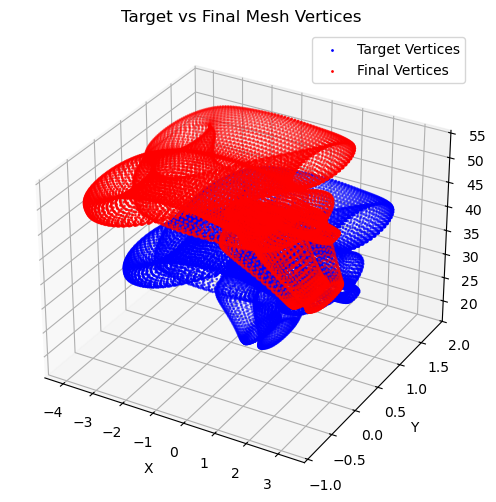

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy arrays for plotting
verts_target_np = verts_target_transformed.cpu().numpy()
verts_final_np = verts_final.cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the target mesh vertices
ax.scatter(
    verts_target_np[:, 0], verts_target_np[:, 1], verts_target_np[:, 2],
    c='blue', label='Target Vertices', s=1
)

# Plot the final mesh vertices
ax.scatter(
    verts_final_np[:, 0], verts_final_np[:, 1], verts_final_np[:, 2],
    c='red', label='Final Vertices', s=1
)

ax.set_title("Target vs Final Mesh Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
